TRANSFER LEARNING FOR COMPUTER VISION

These two major transfer learning scenarios:

1. **Finetuning the ConvNet**: Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.
2. **ConvNet as fixed feature extractor**: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode 

In [4]:
# mount google drive (optional as required)
from google.colab import drive
drive.mount('/content/drive')

# change to project directory (as required)
os.chdir('drive/My Drive/Colab Notebooks')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ant_bees.ipynb	data


We will use torchvision and torch.utils.data packages for loading the data.

We are training a model to ***classify ants and bees***. 
We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet. Download and extract it to the current directory.
https://download.pytorch.org/tutorial/hymenoptera_data.zip

**Get Data**

* Augment and normalize training data
* Normalize validation data

In [5]:
data_transforms = {
    # Data augmentation and normalization for training
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Data normalization for validation
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images to understand data augmentation

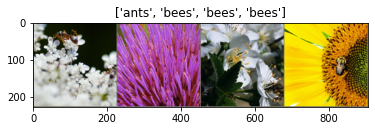

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

**Training the model**

* Scheduling the learning rate using  *torch.optim.lr_scheduler*.
* Saving the best model

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

**Visualize the model predictions**

Generic function to display predictions for a few images

In [24]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('true: {} | predicted: {}'
                  .format(class_names[labels[j]], class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

**Finetuning the ConvNet**

Load a pretrained **ResNet18** model and then optimize the network.

In [15]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

**Train to finetune the ResNet18 and evaluate**

In [18]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 1/25
----------
train Loss: 0.5083 Acc: 0.8115
val Loss: 0.3030 Acc: 0.8693

Epoch 2/25
----------
train Loss: 0.5495 Acc: 0.7910
val Loss: 0.4866 Acc: 0.8235

Epoch 3/25
----------
train Loss: 0.4715 Acc: 0.8279
val Loss: 0.3064 Acc: 0.8693

Epoch 4/25
----------
train Loss: 0.5240 Acc: 0.7910
val Loss: 0.3168 Acc: 0.9020

Epoch 5/25
----------
train Loss: 0.6072 Acc: 0.7787
val Loss: 0.2565 Acc: 0.9085

Epoch 6/25
----------
train Loss: 0.4751 Acc: 0.8115
val Loss: 0.2386 Acc: 0.9150

Epoch 7/25
----------
train Loss: 0.3435 Acc: 0.8402
val Loss: 0.2271 Acc: 0.9216

Epoch 8/25
----------
train Loss: 0.1813 Acc: 0.9303
val Loss: 0.2265 Acc: 0.9150

Epoch 9/25
----------
train Loss: 0.3222 Acc: 0.8852
val Loss: 0.2150 Acc: 0.9281

Epoch 10/25
----------
train Loss: 0.3611 Acc: 0.8484
val Loss: 0.1959 Acc: 0.9477

Epoch 11/25
----------
train Loss: 0.2216 Acc: 0.8975
val Loss: 0.1960 Acc: 0.9281

Epoch 12/25
----------
train Loss: 0.2544 Acc: 0.8852
val Loss: 0.1863 Acc: 0.9281

E

**ConvNet as fixed feature extractor**

* Freeze all of the network except final layer: 

  set *requires_grad == False* to freeze the parameters so that the gradients are not computed in *backward()*

  Autograd mechanics: https://pytorch.org/docs/master/notes/autograd.html

* Optimize the parameters of only the final layer.

In [19]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

**Train the ConvNet to optimize the final layer and evaluate**

Training takes less time as gradients are not needed to be computed in backward for most part of the network other than the final layer.

In [20]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss: 0.6609 Acc: 0.6352
val Loss: 0.4665 Acc: 0.7974

Epoch 2/25
----------
train Loss: 0.5371 Acc: 0.7500
val Loss: 0.1961 Acc: 0.9477

Epoch 3/25
----------
train Loss: 0.5892 Acc: 0.7664
val Loss: 0.2976 Acc: 0.8758

Epoch 4/25
----------
train Loss: 0.3970 Acc: 0.8443
val Loss: 0.2246 Acc: 0.9346

Epoch 5/25
----------
train Loss: 0.4118 Acc: 0.8320
val Loss: 0.2090 Acc: 0.9346

Epoch 6/25
----------
train Loss: 0.6158 Acc: 0.7910
val Loss: 0.2151 Acc: 0.9281

Epoch 7/25
----------
train Loss: 0.4404 Acc: 0.8279
val Loss: 0.2828 Acc: 0.8824

Epoch 8/25
----------
train Loss: 0.3651 Acc: 0.8320
val Loss: 0.1598 Acc: 0.9542

Epoch 9/25
----------
train Loss: 0.3524 Acc: 0.8566
val Loss: 0.1809 Acc: 0.9542

Epoch 10/25
----------
train Loss: 0.3341 Acc: 0.8607
val Loss: 0.1711 Acc: 0.9542

Epoch 11/25
----------
train Loss: 0.2947 Acc: 0.8525
val Loss: 0.1824 Acc: 0.9412

Epoch 12/25
----------
train Loss: 0.2237 Acc: 0.9139
val Loss: 0.1679 Acc: 0.9477

E

**Visualize the models**

Fine tuned pretrained model


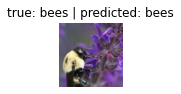

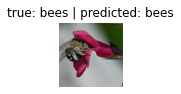

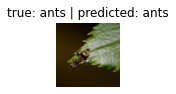

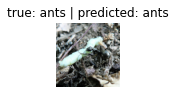

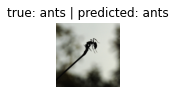

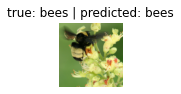


--------------------

Final layer optimized model


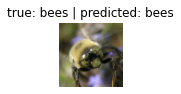

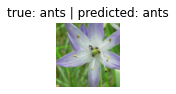

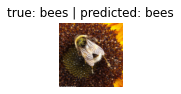

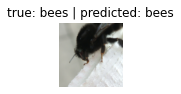

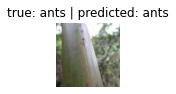

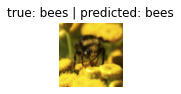

In [26]:
print("Fine tuned pretrained model")
visualize_model(model_ft)
plt.ioff()
plt.show()

print('\n'+'-'*20+'\n')

print("Final layer optimized model")
visualize_model(model_conv)
plt.ioff()
plt.show()